<a href="https://colab.research.google.com/github/Raruu/Machine-Learning-2025/blob/main/JS04/Tugas_Jurnal_Hidayat_Widi_Saputra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: [Data-driven versus a domain-led approach to k-means clustering on an open heart failure dataset](https://link.springer.com/article/10.1007/s41060-022-00346-9)

## Abstract

Domain-driven data mining of health care data poses unique challenges. The aim of this paper is to explore the advantages and the challenges of a ‘domain-led approach’ versus a data-driven approach to a k-means clustering experiment. For the purpose of this experiment, clinical experts in heart failure selected variables to be used during the k-means clustering, whilst during the ‘data-driven approach’ feature selection was performed by applying principal component analysis to the multidimensional dataset. Six out of seven features selected by physicians were amongst 26 features that contributed most to the significant principal components within the k-means algorithm. The data-driven approach showed advantage over the domain-led approach for feature selection by removing the risk of bias that can be introduced by domain experts. Whilst the ‘domain-led approach’ may potentially prohibit knowledge discovery that can be hidden behind variables not routinely taken into consideration as clinically important features, the domain knowledge played an important role at the interpretation stage of the clustering experiment providing insight into the context and preventing far fetched conclusions. The “data-driven approach” was accurate in identifying clusters with distinct features at the physiological level. To promote the domain-led data mining approach, as a result of this experiment we developed a practical checklist guiding how to enable the integration of the domain knowledge into the data mining project.

Dataset: https://physionet.org/content/heart-failure-zigong/1.0/


# Eksplorasi Data dan Pra-Pemrosesan Data

In [1]:
import os, shutil, sys, zipfile

DATASET_PATH = os.path.join(os.getcwd(), "heart-failure-zigong-1.0")

try:
  from google.colab import output
  import zipfile
  from google.colab import files
  if not os.path.exists(DATASET_PATH) and 'google.colab' in sys.modules:
    zip_file = files.upload()
except:
    zip_file = './hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.0.zip'

def setup_dataset(zip_file):
  if zip_file is not str:
    zip_filename = next(iter(zip_file))
  else:
    zip_filename = zip_file

  if not os.path.exists(DATASET_PATH):
      os.makedirs(DATASET_PATH)

  with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
      zip_ref.extractall(DATASET_PATH)

  print(f"Successfully extracted '{zip_filename}' to '{DATASET_PATH}' folder.")

  for name in os.listdir(DATASET_PATH):
    path = os.path.join(DATASET_PATH, name)
    if os.path.isdir(path):
        for item_name in os.listdir(path):
          source_item = os.path.join(path, item_name)
          destination_item = os.path.join(DATASET_PATH, item_name)

          shutil.move(source_item, destination_item)
          print(f"Moved: {item_name}")

    os.rmdir(path)
    print(f"Successfully cleaned up and removed empty folder: {os.path.basename(path)}")

if not os.path.exists(DATASET_PATH):
  setup_dataset(zip_file)

Saving hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.0.zip to hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.0.zip
Successfully extracted 'hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.0.zip' to '/content/heart-failure-zigong-1.0' folder.
Moved: dat.csv
Moved: SHA256SUMS.txt
Moved: LICENSE.txt
Moved: dataDictionary.csv
Successfully cleaned up and removed empty folder: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

DOMAIN_FEATURES_WANTED = [
   "LVEF",
   "left.ventricular.end.diastolic.diameter.LV",
   "brain.natriuretic.peptide",
   "high.sensitivity.troponin",
   "fibrinogen", # 34
   "hemoglobin",
   "cholesterol", # 198
   "total.protein",
   "calcium", # 11
   "urea",
   "glomerular.filtration.rate",
   "lactate.dehydrogenase",
   "creatine.kinase"
]


df = pd.read_csv(os.path.join(DATASET_PATH, "dat.csv"))
df.head(5)


,Unnamed: 0,No.,Way.of.leaving.hospital,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,height,BMI,type.of.heart.failure,NYHA.cardiac.function.classification,Killip.grade,myocardial.infarction,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,connective.tissue.disease,peptic.ulcer.disease,diabetes,moderate.to.severe.chronic.kidney.disease,hemiplegia,leukemia,malignant.lymphoma,solid.tumor,liver.disease,AIDS,CCI.score,type.II.respiratory.failure,consciousness,eye.opening,verbal.response,movement,respiratory.support.,oxygen.inhalation,fio2,acute.renal.failure,LVEF,left.ventricular.end.diastolic.diameter.LV,mitral.valve.EMS,mitral.valve.AMS,EA,tricuspid.valve.return.velocity,tricuspid.valve.return.pressure,outcome.during.hospitalization,death.within.28.days,re.admission.within.28.days,death.within.3.months,re.admission.within.3.months,death.within.6.months,re.admission.within.6.months,time.of.death..days.from.admission.,re.admission.time..days.from.admission.,return.to.emergency.department.within.6.months,time.to.emergency.department.within.6.months,creatinine.enzymatic.method,urea,uric.acid,glomerular.filtration.rate,cystatin,white.blood.cell,monocyte.ratio,monocyte.count,red.blood.cell,coefficient.of.variation.of.red.blood.cell.distribution.width,standard.deviation.of.red.blood.cell.distribution.width,mean.corpuscular.volume,hematocrit,lymphocyte.count,mean.hemoglobin.volume,mean.hemoglobin.concentration,mean.platelet.volume,basophil.ratio,basophil.count,eosinophil.ratio,eosinophil.count,hemoglobin,platelet,platelet.distribution.width,platelet.hematocrit,neutrophil.ratio,neutrophil.count,D.dimer,international.normalized.ratio,activated.partial.thromboplastin.time,thrombin.time,prothrombin.activity,prothrombin.time.ratio,fibrinogen,high.sensitivity.troponin,myoglobin,carbon.dioxide.binding.capacity,calcium,potassium,chloride,sodium,Inorganic.Phosphorus,serum.magnesium,creatine.kinase.isoenzyme.to.creatine.kinase,hydroxybutyrate.dehydrogenase.to.lactate.dehydrogenase,hydroxybutyrate.dehydrogenase,glutamic.oxaloacetic.transaminase,creatine.kinase,creatine.kinase.isoenzyme,lactate.dehydrogenase,brain.natriuretic.peptide,high.sensitivity.protein,nucleotidase,fucosidase,albumin,white.globulin.ratio,cholinesterase,glutamyltranspeptidase,glutamic.pyruvic.transaminase,glutamic.oxaliplatin,indirect.bilirubin,alkaline.phosphatase,globulin,direct.bilirubin,total.bilirubin,total.bile.acid,total.protein,erythrocyte.sedimentation.rate,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,homocysteine,apolipoprotein.A,apolipoprotein.B,lipoprotein,pH,standard.residual.base,standard.bicarbonate,partial.pressure.of.carbon.dioxide,total.carbon.dioxide,methemoglobin,hematocrit.blood.gas,reduced.hemoglobin,potassium.ion,chloride.ion,sodium.ion,glucose.blood.gas,lactate,measured.residual.base,measured.bicarbonate,carboxyhemoglobin,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat
0,1,1,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,19,102,64,76.666667,50.0,1.64,18.590125,Both,III,III,0,0,0,0,0,1,0,0.0,1,0.0,0,0,0,0,0.0,0,2.0,NonTypeII,Clear,4,5,6,NaN,OxygenTherapy,33,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alive,0,0,0,0,0,0,NaN,NaN,0.0,NaN,108.3,12.55,685.0,58.57,1.32,9.43,0.085,0.80,4.09,15.0,50.3,94.5,0.387,1.51,32.0,338.0,14.0,0.006,0.05,0.002,0.02,131.0,102.0,16.6,0.142,0.746,7.05,1.19,1.39,33.4,17.0,60.3,1.37,3.84,0.094,NaN,21.6,2.28,5.59,101.9,134.6,NaN,NaN,0.22,0.63,185.0,81.0,43.0,9.6,294.0,1500.17,7.6,3.5,20.5,38.1,1.6,NaN,83.0,65.0,1.02,11.4,61.0,23.8,6.9,18.3,4.9,61.9,NaN,3.46,1.90,2.69,0.84,NaN,NaN,NaN,NaN,7.44,-3.0,22.7,32.0,22.2,0.3,37.0,3.4,5.63,103.0,136.4,5.8,2.5,-2.1,21.2,0.4,37.0,97.0

In [3]:
df[DOMAIN_FEATURES_WANTED].isnull().sum()

,0
LVEF,1373
left.ventricular.end.diastolic.diameter.LV,697
brain.natriuretic.peptide,35
high.sensitivity.troponin,79
fibrinogen,34
hemoglobin,28
cholesterol,198
total.protein,102
calcium,11
urea,23


In [4]:
variables_68 = [
    'LVEF',
    'brain.natriuretic.peptide',
    'hemoglobin',
    'mean.corpuscular.volume',
    'creatinine.enzymatic.method',
    'sodium',
    'albumin',
    'pulse',
    'weight',
    'height',
    'fio2',
    'white.blood.cell',
    'monocyte.ratio',
    'standard.deviation.of.red.blood.cell.distribution.width',
    'mean.hemoglobin.volume',
    'mean.platelet.volume',
    'eosinophil.ratio',
    'eosinophil.count',
    'neutrophil.ratio',
    'neutrophil.count',
    'prothrombin.activity',
    'carbon.dioxide.binding.capacity',
    'potassium',
    'white.globulin.ratio',
    'cholesterol',
    'low.density.lipoprotein.cholesterol',
    'GCS',
    'D.dimer',
    'international.normalized.ratio',
    'activated.partial.thromboplastin.time',
    'thrombin.time',
    'prothrombin.time.ratio',
    'fibrinogen',
    'urea',
    'uric.acid',
    'glomerular.filtration.rate',
    'calcium',
    'chloride',
    'Inorganic.Phosphorus',
    'serum.magnesium',
    'triglyceride',
    'high.density.lipoprotein.cholesterol',
    'red.blood.cell',
    'hematocrit',
    'lymphocyte.count',
    'mean.hemoglobin.concentration',
    'platelet',
    'platelet.distribution.width',
    'platelet.hematocrit',
    'total.protein',
    'total.bilirubin',
    'direct.bilirubin',
    'indirect.bilirubin',
    'alkaline.phosphatase',
    'glutamyltranspeptidase',
    'glutamic.pyruvic.transaminase',
    'globulin',
    'BMI',
    'systolic.blood.pressure',
    'diastolic.blood.pressure',
    'map',
    'respiration',
    'high.sensitivity.troponin',
    'left.ventricular.end.diastolic.diameter.LV',
    'total.hemoglobin'
]

df_filtered = df.dropna(subset=['LVEF'])
df_filtered = df_filtered.select_dtypes(np.number)
df_filtered = df_filtered[variables_68]
df_filtered.head(5)

,LVEF,brain.natriuretic.peptide,hemoglobin,mean.corpuscular.volume,creatinine.enzymatic.method,sodium,albumin,pulse,weight,height,fio2,white.blood.cell,monocyte.ratio,standard.deviation.of.red.blood.cell.distribution.width,mean.hemoglobin.volume,mean.platelet.volume,eosinophil.ratio,eosinophil.count,neutrophil.ratio,neutrophil.count,prothrombin.activity,carbon.dioxide.binding.capacity,potassium,white.globulin.ratio,cholesterol,low.density.lipoprotein.cholesterol,GCS,D.dimer,international.normalized.ratio,activated.partial.thromboplastin.time,thrombin.time,prothrombin.time.ratio,fibrinogen,urea,uric.acid,glomerular.filtration.rate,calcium,chloride,Inorganic.Phosphorus,serum.magnesium,triglyceride,high.density.lipoprotein.cholesterol,red.blood.cell,hematocrit,lymphocyte.count,mean.hemoglobin.concentration,platelet,platelet.distribution.width,platelet.hematocrit,total.protein,total.bilirubin,direct.bilirubin,indirect.bilirubin,alkaline.phosphatase,glutamyltranspeptidase,glutamic.pyruvic.transaminase,globulin,BMI,systolic.blood.pressure,diastolic.blood.pressure,map,respiration,high.sensitivity.troponin,left.ventricular.end.diastolic.diameter.LV,total.hemoglobin
500,20.0,3827.40,169.0,100.5,134.3,137.7,40.7,80,60.0,1.68,40,19.08,0.014,47.4,34.6,11.7,0.002,0.04,0.864,16.48,100.2,20.3,4.00,1.2,6.85,4.51,12,10.53,1.00,29.1,14.1,1.00,2.91,10.70,610.0,49.12,2.50,98.4,2.3,1.0,1.16,1.56,4.89,0.492,2.22,344.0,208.0,16.4,0.243,75.7,12.9,2.7,10.2,126.0,79.0,22.0,35.0,21.258503,164,85,111.333333,18,0.290,75.0,NaN
501,64.0,451.00,116.0,67.1,74.6,142.2,39.3,80,48.0,1.50,33,5.31,0.096,39.0,22.0,10.3,0.021,0.11,0.586,3.11,74.0,25.4,3.89,1.2,5.28,3.37,15,7.58,1.19,35.1,18.7,1.20,2.06,7.36,387.0,63.67,2.18,105.2,NaN,NaN,1.21,1.07,5.30,0.356,1.55,327.0,203.0,15.6,0.209,72.0,24.9,6.9,18.0,82.0,34.0,17.0,32.7,21.333333,140,60,86.666667,21,0.044,44.0,NaN
503,52.0,857.46,120.0,92.8,95.0,141.0,32.2,78,77.0,1.55,33,5.82,0.072,51.8,29.0,12.6,0.007,0.04,0.780,4.54,64.1,24.0,3.15,1.1,2.28,1.21,15,1.07,1.17,34.9,18.8,1.18,2.39,6.00,470.0,47.54,2.14,102.4,NaN,NaN,0.83,0.72,4.14,0.384,0.79,313.0,164.0,16.2,0.210,62.7,17.2,8.1,9.1,44.0,20.0,16.0,30.5,32.049948,166,98,120.666667,20,0.024,39.0,170.0
505,63.0,1720.67,55.0,81.8,604.4,136.8,33.3,81,35.0,1.42,33,5.04,0.053,51.4,26.0,10.4,0.004,0.02,0.893,4.50,79.4,19.2,6.66,0.9,3.65,1.52,15,23.57,1.15,36.4,18.0,1.15,2.78,31.81,581.0,5.00,2.07,107.2,NaN,NaN,1.69,1.13,2.12,0.174,0.24,318.0,190.0,16.3,0.199,72.2,2.9,1.2,1.7,84.0,25.0,20.0,38.9,17.357667,156,70,98.666667,19,0.133,41.0,59.0
506,66.0,876.28,130.0,113.0,60.8,140.3,38.5,80,50.0,1.60,33,5.59,0.096,52.0,38.9,13.8,0.020,0.11,0.746,4.17,74.0,23.5,3.49,1.5,2.18,0.71,15,3.04,1.19,34.5,16.2,1.20,3.44,5.99,673.0,116.06,2.32,104.2,NaN,NaN,0.66,1.05,3.34,0.378,0.73,345.0,114.0,16.3,0.158,64.4,14.4,6.3,8.1,110.0,58.0,44.0,25.9,19.531250,110,60,76.666667,19,0.042,48.0,NaN


In [5]:
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

df_final_68 = df_normalized

df_final_68.head(5)

,LVEF,brain.natriuretic.peptide,hemoglobin,mean.corpuscular.volume,creatinine.enzymatic.method,sodium,albumin,pulse,weight,height,fio2,white.blood.cell,monocyte.ratio,standard.deviation.of.red.blood.cell.distribution.width,mean.hemoglobin.volume,mean.platelet.volume,eosinophil.ratio,eosinophil.count,neutrophil.ratio,neutrophil.count,prothrombin.activity,carbon.dioxide.binding.capacity,potassium,white.globulin.ratio,cholesterol,low.density.lipoprotein.cholesterol,GCS,D.dimer,international.normalized.ratio,activated.partial.thromboplastin.time,thrombin.time,prothrombin.time.ratio,fibrinogen,urea,uric.acid,glomerular.filtration.rate,calcium,chloride,Inorganic.Phosphorus,serum.magnesium,triglyceride,high.density.lipoprotein.cholesterol,red.blood.cell,hematocrit,lymphocyte.count,mean.hemoglobin.concentration,platelet,platelet.distribution.width,platelet.hematocrit,total.protein,total.bilirubin,direct.bilirubin,indirect.bilirubin,alkaline.phosphatase,glutamyltranspeptidase,glutamic.pyruvic.transaminase,globulin,BMI,systolic.blood.pressure,diastolic.blood.pressure,map,respiration,high.sensitivity.troponin,left.ventricular.end.diastolic.diameter.LV,total.hemoglobin
0,0.194805,0.765354,0.920000,0.707276,0.109165,0.676923,0.720000,0.324324,0.590909,0.857143,0.240506,0.698121,0.071429,0.279678,0.815451,0.400000,0.010695,0.032787,0.8368,0.681217,0.691509,0.303030,0.439623,0.363636,0.771596,0.863071,0.75,0.117039,0.024818,0.100955,0.036820,0.021962,0.307298,0.265662,0.529981,0.177811,0.560606,0.565757,0.659176,0.602564,0.041404,0.529880,0.700704,0.869469,0.405303,0.893204,0.308998,0.423841,0.362218,0.638783,0.080845,0.030343,0.129222,0.283019,0.104668,0.006165,0.396648,0.533723,0.784689,0.653846,0.742222,0.1250,0.010854,0.871645,0.589655
1,0.766234,0.089710,0.566667,0.142132,0.045020,0.815385,0.676923,0.324324,0.454545,0.535714,0.151899,0.123173,0.559524,0.110664,0.274678,0.244444,0.112299,0.090164,0.3920,0.091711,0.495855,0.457576,0.418868,0.363636,0.541728,0.626556,1.00,0.084250,0.052555,0.182810,0.075314,0.051245,0.198464,0.166962,0.314313,0.234671,0.398990,0.734491,0.174157,0.429487,0.043654,0.334661,0.772887,0.568584,0.278409,0.728155,0.300509,0.370861,0.303293,0.568441,0.168245,0.085752,0.243759,0.144654,0.041018,0.004543,0.353818,0.535967,0.669856,0.461538,0.577778,0.3125,0.001647,0.509918,0.589655
2,0.610390,0.171046,0.593333,0.576988,0.066939,0.778462,0.458462,0.310811,0.784091,0.625000,0.151899,0.144468,0.416667,0.368209,0.575107,0.500000,0.037433,0.032787,0.7024,0.154762,0.421925,0.415152,0.279245,0.318182,0.102489,0.178423,1.00,0.011893,0.049635,0.180082,0.076151,0.048316,0.240717,0.126773,0.394584,0.171636,0.378788,0.665012,0.174157,0.429487,0.026553,0.195219,0.568662,0.630531,0.134470,0.592233,0.234295,0.410596,0.305026,0.391635,0.112163,0.101583,0.113069,0.025157,0.021216,0.004218,0.312849,0.857373,0.794258,0.753846,0.804444,0.2500,0.000898,0.451575,0.882759
3,0.753247,0.343781,0.160000,0.390863,0.614269,0.649231,0.492308,0.331081,0.306818,0.392857,0.151899,0.111900,0.303571,0.360161,0.446352,0.255556,0.021390,0.016393,0.8832,0.152998,0.536181,0.269697,0.941509,0.227273,0.303075,0.242739,1.00,0.261976,0.046715,0.200546,0.069456,0.043924,0.290653,0.889480,0.501934,0.005393,0.343434,0.784119,0.174157,0.429487,0.065257,0.358566,0.213028,0.165929,0.030303,0.640777,0.278438,0.417219,0.285962,0.572243,0.008012,0.010554,0.004405,0.150943,0.028289,0.005516,0.469274,0.416732,0.746411,0.538462,0.657778,0.1875,0.004978,0.474912,0.117241
4,0.792208,0.174812,0.660000,0.918782,0.030192,0.756923,0.652308,0.324324,0.477273,0.714286,0.151899,0.134864,0.559524,0.372233,1.000000,0.633333,0.106952,0.090164,0.6480,0.138448,0.495855,0.400000,0.343396,0.500000,0.087848,0.074689,1.00,0.033789,0.052555,0.174625,0.054393,0.051245,0.375160,0.126478,0.590909,0.439408,0.469697,0.709677,0.174157,0.429487,0.018902,0.326693,0.427817,0.617257,0.123106,0.902913,0.149406,0.417219,0.214905,0.423954,0.091770,0.077836,0.098385,0.232704,0.074965,0.013303,0.227188

# Eksperimen 1 - Pendekatan Domain-Led

In [6]:
domain_features = ['LVEF', 'brain.natriuretic.peptide', 'hemoglobin',
                   'mean.corpuscular.volume', 'creatinine.enzymatic.method',
                   'sodium', 'albumin']

df_domain = df_final_68[domain_features]
df_domain.shape

(635, 7)

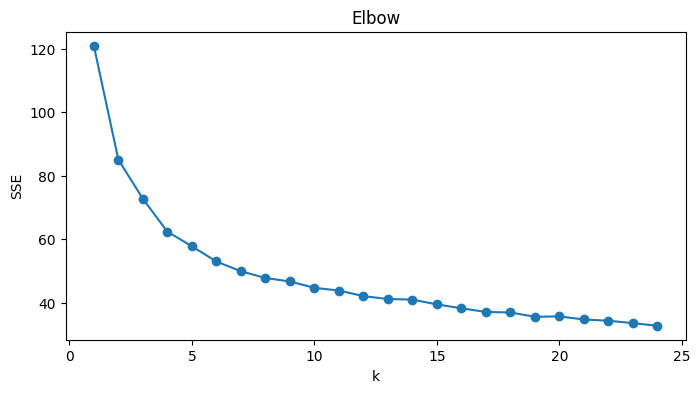

In [7]:
sse = []
K = range(1, 25)
for k in K:
 kmeanModel = KMeans(n_clusters=k)
 kmeanModel.fit(df_domain)
 sse.append(kmeanModel.inertia_)


plt.figure(figsize=(8,4))
plt.plot(K, sse, "o-")
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Elbow")
plt.show()

In [8]:
optimal_k = 4

kmeans_domain = KMeans(n_clusters=optimal_k, random_state=421227, n_init=10)
clusters_domain = kmeans_domain.fit_predict(df_domain)

df_domain_results = df_filtered.copy()
df_domain_results['Cluster_Domain'] = clusters_domain

df_domain_results.groupby('Cluster_Domain')[domain_features].median()

,LVEF,brain.natriuretic.peptide,hemoglobin,mean.corpuscular.volume,creatinine.enzymatic.method,sodium,albumin
Cluster_Domain,,,,,,,
0,39.0,1570.920,125.0,93.60,82.30,139.55,36.50
1,60.0,308.750,123.0,94.30,70.65,140.25,38.15
2,43.0,4486.850,116.5,91.55,101.85,137.80,36.00
3,58.0,516.505,86.5,85.55,89.40,138.60,33.60


# Eksperimen 2 - Pendekatan Berbasis Data

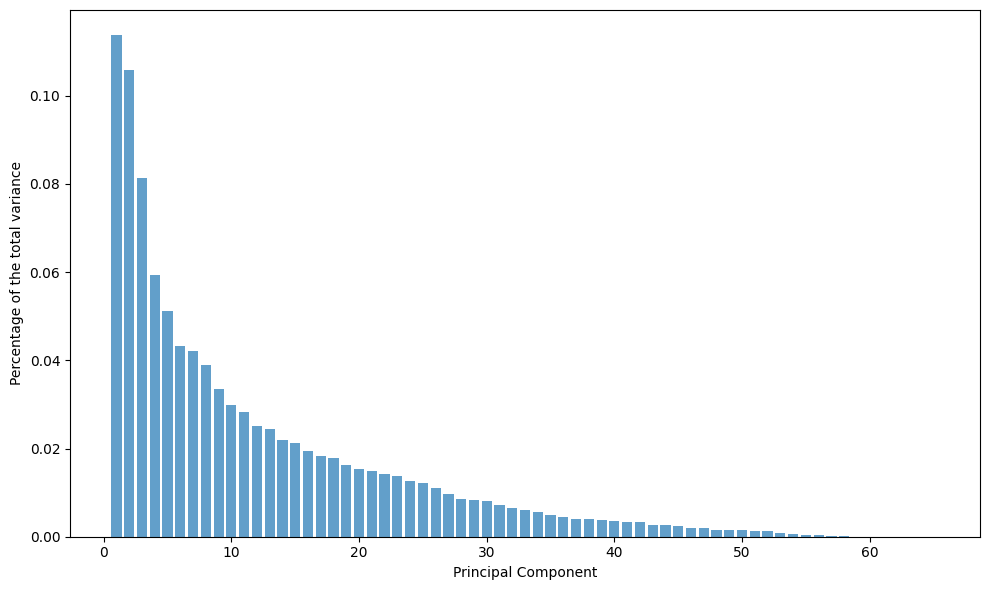

In [9]:
pca = PCA()
pca.fit(df_final_68)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')

plt.ylabel('Percentage of the total variance')
plt.xlabel('Principal Component')
plt.tight_layout()
plt.show()

In [10]:
num_pcs = 22
pca_transformer = PCA(n_components=num_pcs)
pcs = pca_transformer.fit_transform(df_final_68)

# Matriks baru untuk clustering: 635 x 22 [16]
df_pcs = pd.DataFrame(pcs, index=df_final_68.index)

df_pcs.shape

(635, 22)

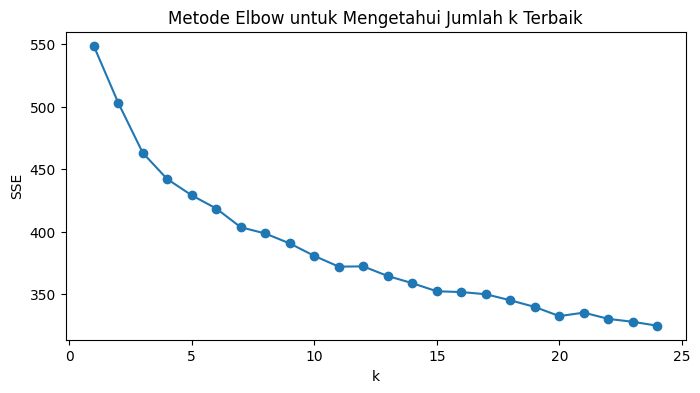

In [11]:
sse = []
K = range(1, 25)
for k in K:
 kmeanModel = KMeans(n_clusters=k)
 kmeanModel.fit(df_pcs)
 sse.append(kmeanModel.inertia_)


plt.figure(figsize=(8,4))
plt.plot(K, sse, "o-")
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Metode Elbow untuk Mengetahui Jumlah k Terbaik")
plt.show()

In [12]:
optimal_k = 4

kmeans_data_driven = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_data_driven = kmeans_data_driven.fit_predict(df_pcs)

df_data_driven_results = df_filtered.copy()
df_data_driven_results['Cluster_Data_Driven'] = clusters_data_driven


top_26_features = [
    'pulse',
    'weight',
    'height',
    'fio2',
    'LVEF',
    'white.blood.cell',
    'monocyte.ratio',
    'standard.deviation.of.red.blood.cell.distribution.width',
    'mean.corpuscular.volume',
    'mean.hemoglobin.volume',
    'mean.platelet.volume',
    'eosinophil.ratio',
    'eosinophil.count',
    'hemoglobin',
    'neutrophil.ratio',
    'neutrophil.count',
    'prothrombin.activity',
    'carbon.dioxide.binding.capacity',
    'potassium',
    'sodium',
    'brain.natriuretic.peptide',
    'albumin',
    'white.globulin.ratio',
    'cholesterol',
    'low.density.lipoprotein.cholesterol',
    'GCS'
]


df_data_driven_results.groupby('Cluster_Data_Driven')[top_26_features].median()

,pulse,weight,height,fio2,LVEF,white.blood.cell,monocyte.ratio,standard.deviation.of.red.blood.cell.distribution.width,mean.corpuscular.volume,mean.hemoglobin.volume,mean.platelet.volume,eosinophil.ratio,eosinophil.count,hemoglobin,neutrophil.ratio,neutrophil.count,prothrombin.activity,carbon.dioxide.binding.capacity,potassium,sodium,brain.natriuretic.peptide,albumin,white.globulin.ratio,cholesterol,low.density.lipoprotein.cholesterol,GCS
Cluster_Data_Driven,,,,,,,,,,,,,,,,,,,,,,,,,,
0,83.5,50.0,1.565,33.0,57.5,6.070,0.0675,49.9,89.05,27.55,10.9,0.008,0.05,79.0,0.7905,4.825,66.75,22.25,3.950,138.80,626.86,33.20,1.20,2.980,1.320,15.0
1,80.0,50.0,1.550,33.0,54.0,5.745,0.0660,47.1,93.85,30.70,12.5,0.017,0.10,120.0,0.7040,3.945,73.20,25.20,3.750,141.00,488.40,37.30,1.40,3.745,1.790,15.0
2,86.0,50.0,1.580,33.0,40.0,6.530,0.0680,48.8,92.60,30.70,12.6,0.005,0.03,121.0,0.7620,5.050,56.35,20.90,3.990,137.85,3896.87,36.20,1.35,3.565,1.855,15.0
3,90.0,50.0,1.560,33.0,52.0,9.730,0.0610,46.6,92.00,30.60,12.0,0.003,0.03,128.0,0.8295,7.790,72.40,24.20,3.725,137.50,625.97,37.05,1.30,4.460,2.340,15.0


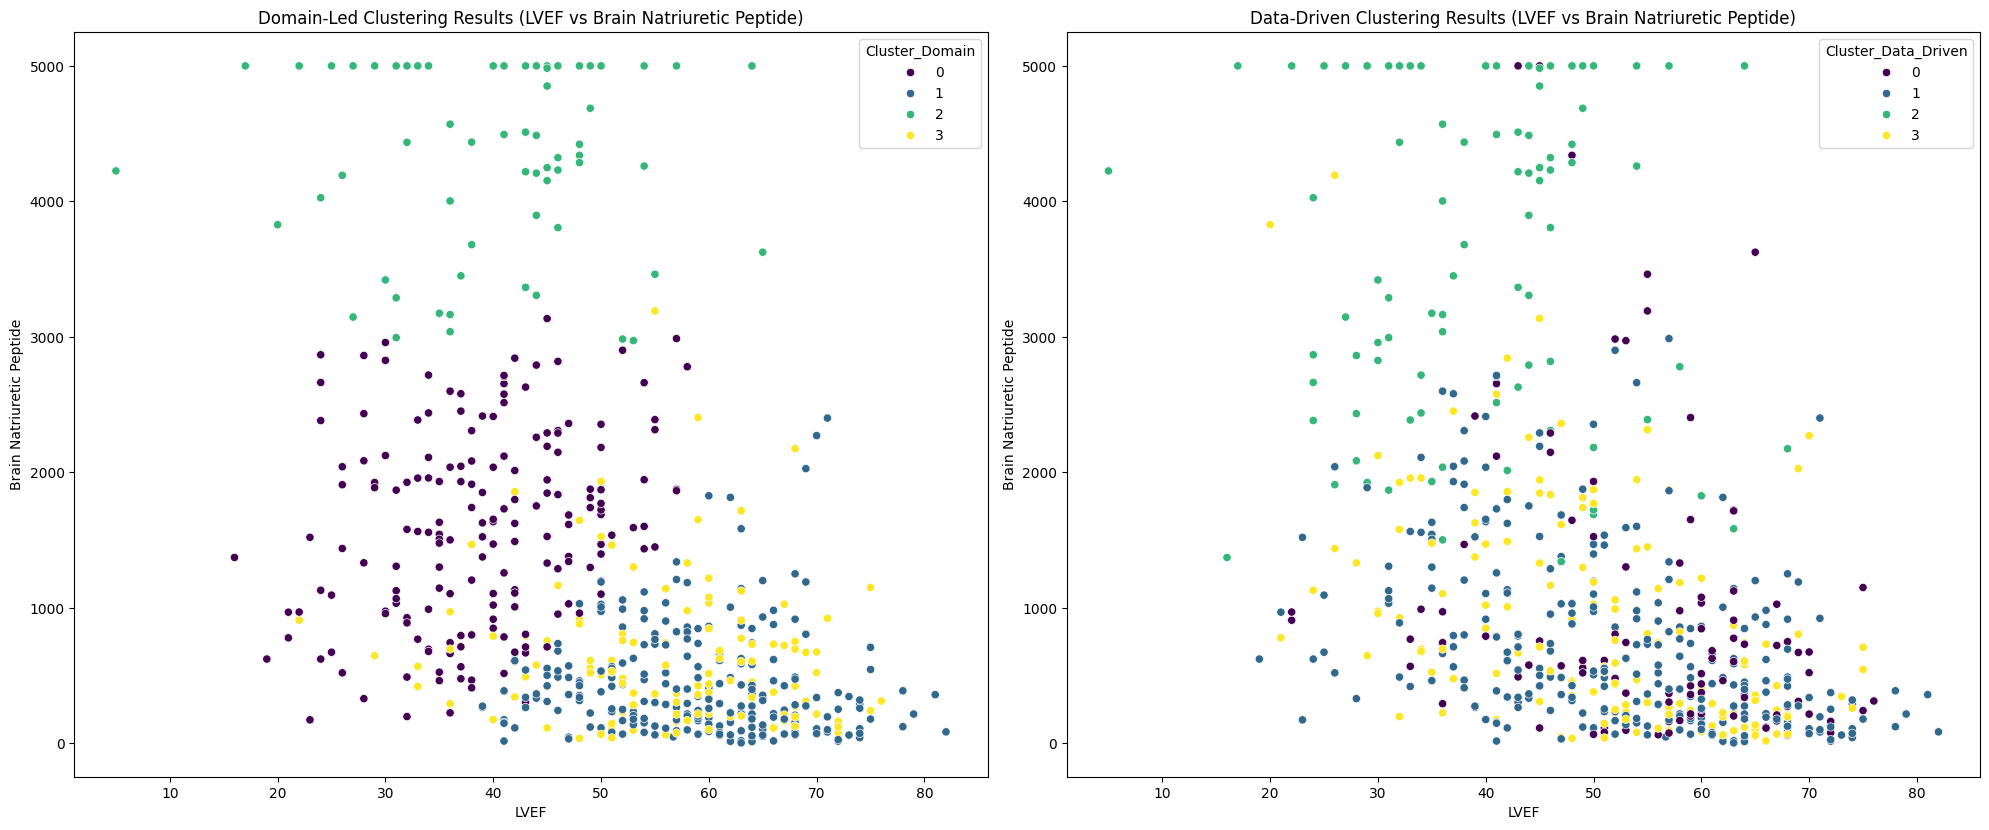

In [18]:
plt.figure(figsize=(20, 16))

# Subplot 1: Domain-Led Clustering Results (LVEF vs Brain Natriuretic Peptide)
plt.subplot(2, 2, 1)
sns.scatterplot(x='LVEF', y='brain.natriuretic.peptide', hue='Cluster_Domain', data=df_domain_results, palette='viridis')
plt.title('Domain-Led Clustering Results (LVEF vs Brain Natriuretic Peptide)')
plt.xlabel('LVEF')
plt.ylabel('Brain Natriuretic Peptide')

# Subplot 2: Data-Driven Clustering Results (LVEF vs Brain Natriuretic Peptide)
plt.subplot(2, 2, 2)
sns.scatterplot(x='LVEF', y='brain.natriuretic.peptide', hue='Cluster_Data_Driven', data=df_data_driven_results, palette='viridis')
plt.title('Data-Driven Clustering Results (LVEF vs Brain Natriuretic Peptide)')
plt.xlabel('LVEF')
plt.ylabel('Brain Natriuretic Peptide')

plt.tight_layout()
plt.show()